# Calculation of dizziness on a train ride from Stockholm to Gothenburg

In [5]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import getpass

# Enable inline plots for matplotlib
%matplotlib inline
password = getpass.getpass()
conn_string = "host='localhost' dbname='osm' user='username' password='%s'"%password
conn = psycopg2.connect(conn_string)

font = {'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

········


## Extract railway lines from Open Street Map
The object id was identified manually in postgresql by searching for names. Cityterminalen (the bus terminal in central Stockholm) was selected as starting point for measuring the distance from destination. Open Street Map data (points, lines, polygons, ...) are loaded with the PostGIS extension. Coordinates are represented in the Swedish grid Sweref99 (SRID 3006) to get metric units.

In [22]:
# Cityterminalen Stockholm:
start_osm_point_id = 472644577
# City of Gothenburg:
end_osm_point_id = 25930131

# Västra Stambanan:
railway_osm_line_in = -35274

In [3]:
rway = pd.read_sql("""
    SELECT 
        segment_id,
        ST_X((dp).geom) x,
        ST_Y((dp).geom) y,
        ST_Distance((dp).geom, (
            SELECT ST_Transform(way, 3006) FROM planet_osm_point
            WHERE osm_id  = {startpoint}
        )) AS dist_from_dest,
        ROW_NUMBER() OVER (PARTITION BY segment_id) rid
    FROM (
        SELECT
            segment_id,
            ST_DumpPoints(ST_Transform(way, 3006)) AS dp
        FROM ( 
            SELECT way, ROW_NUMBER() OVER () AS segment_id 
            FROM planet_osm_line
            WHERE osm_id = {railway}
        ) vstamb
    ) pdump
""".format(startpoint=start_osm_point_id, railway=railway_osm_line_in), conn)

rway.head(5)

,segment_id,x,y,dist_from_dest,rid
0,1,320029.117687,6.400400e+06,397257.666230,1
1,1,320004.060376,6.400393e+06,397283.026619,2
2,1,319746.408735,6.400320e+06,397545.639330,3
3,2,348316.922840,6.416369e+06,364805.370389,1
4,2,348263.447576,6.416342e+06,364865.359520,2


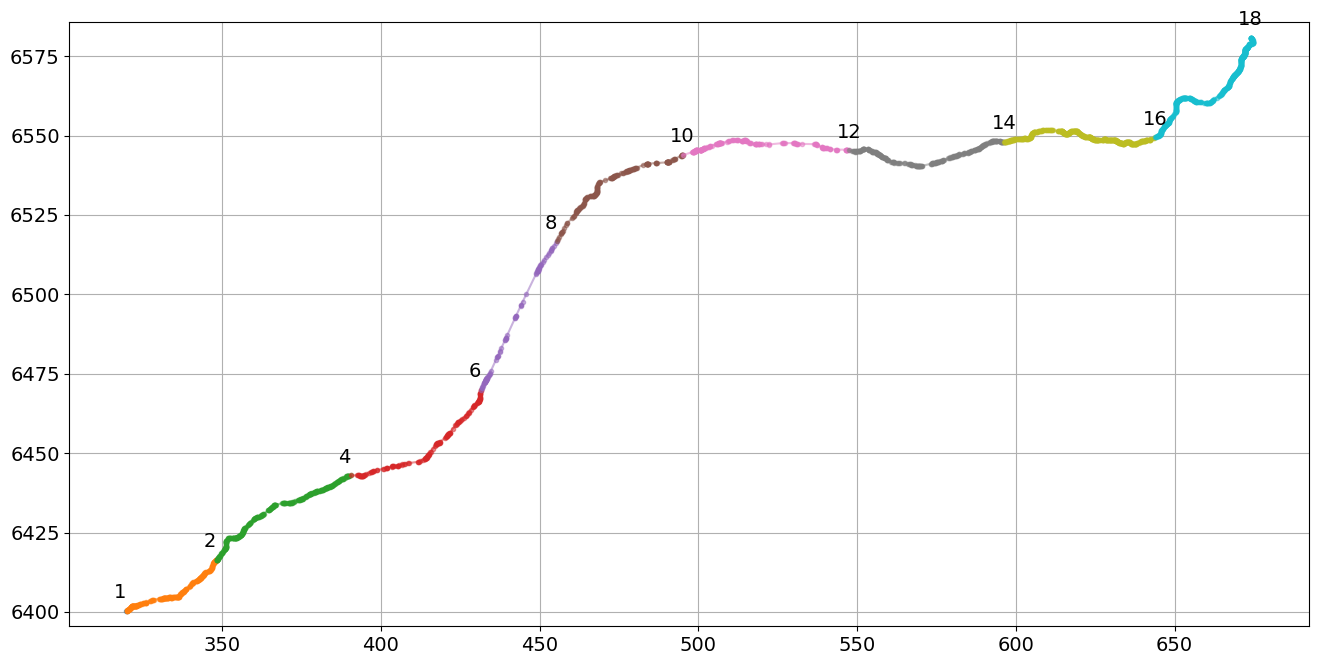

In [4]:
plt.figure(figsize=(16,8), dpi=100)
grouped = rway.groupby('segment_id')
relevant_segments = []
for seg_id, group in grouped:
    # Only select segments moving away from destination
    if group['dist_from_dest'].iloc[0] < group['dist_from_dest'].iloc[-1]:
        plt.plot(group['x']/1e3, group['y']/1e3, '.-', alpha=.5);
        plt.text(group['x'].values[0]/1e3-4, group['y'].values[0]/1e3+4, seg_id)
        relevant_segments.append(seg_id)
plt.axis('equal')
plt.grid()

## Only keep the segments moving away from Stockholm
Exclude the opposite track to avoid mixed tracks.
Sort by distance to Stockholm

In [5]:
rway = rway[rway.segment_id.isin(relevant_segments)] #.sort_values(by='dist_sthlm')

# Construct the entire rout from the segments in order of increasing distance
# It may either be in the correct order already or opposite order
first_seg = rway[rway['segment_id'] == relevant_segments[0]]
last_seg = rway[rway['segment_id'] == relevant_segments[-1]]
if first_seg['dist_from_dest'].iloc[0] > last_seg['dist_from_dest'].iloc[0]:
    rway = rway.sort_values(by=['segment_id', 'rid'], ascending=[False, True])


In [6]:
rway.head()

,segment_id,x,y,dist_from_dest,rid
4604,18,673918.454253,6.580822e+06,59.692449,1
4605,18,673946.437579,6.580790e+06,94.781533,2
4606,18,674003.230282,6.580707e+06,191.926499,3
4607,18,674019.764755,6.580683e+06,220.878749,4
4608,18,674032.013638,6.580661e+06,246.756753,5


## Estimate line curvature
### 1) First naive attempt: look at the distance between points
Assuming that the frequency of points is higher in curves.
We use the distance from Stockholm as axis and plot the inverted distance between points.

In [7]:
# Calculate gradients
dxy = pd.np.gradient(rway.loc[:, ['x','y']], axis=0)
d2xy = pd.np.gradient(dxy, axis=0)

In [8]:
# Add cumulative distance from Stockholm
rway['cumdist'] = pd.np.cumsum(pd.np.sqrt((dxy**2).sum(axis=1)))
rway.head()

,segment_id,x,y,dist_from_dest,rid,cumdist
4604,18,673918.454253,6.580822e+06,59.692449,1,42.471221
4605,18,673946.437579,6.580790e+06,94.781533,2,113.599343
4606,18,674003.230282,6.580707e+06,191.926499,3,178.233647
4607,18,674019.764755,6.580683e+06,220.878749,4,205.782779
4608,18,674032.013638,6.580661e+06,246.756753,5,227.876383


#### Plot absolute gradient, inverted
Use a moving average to smooth the curve.

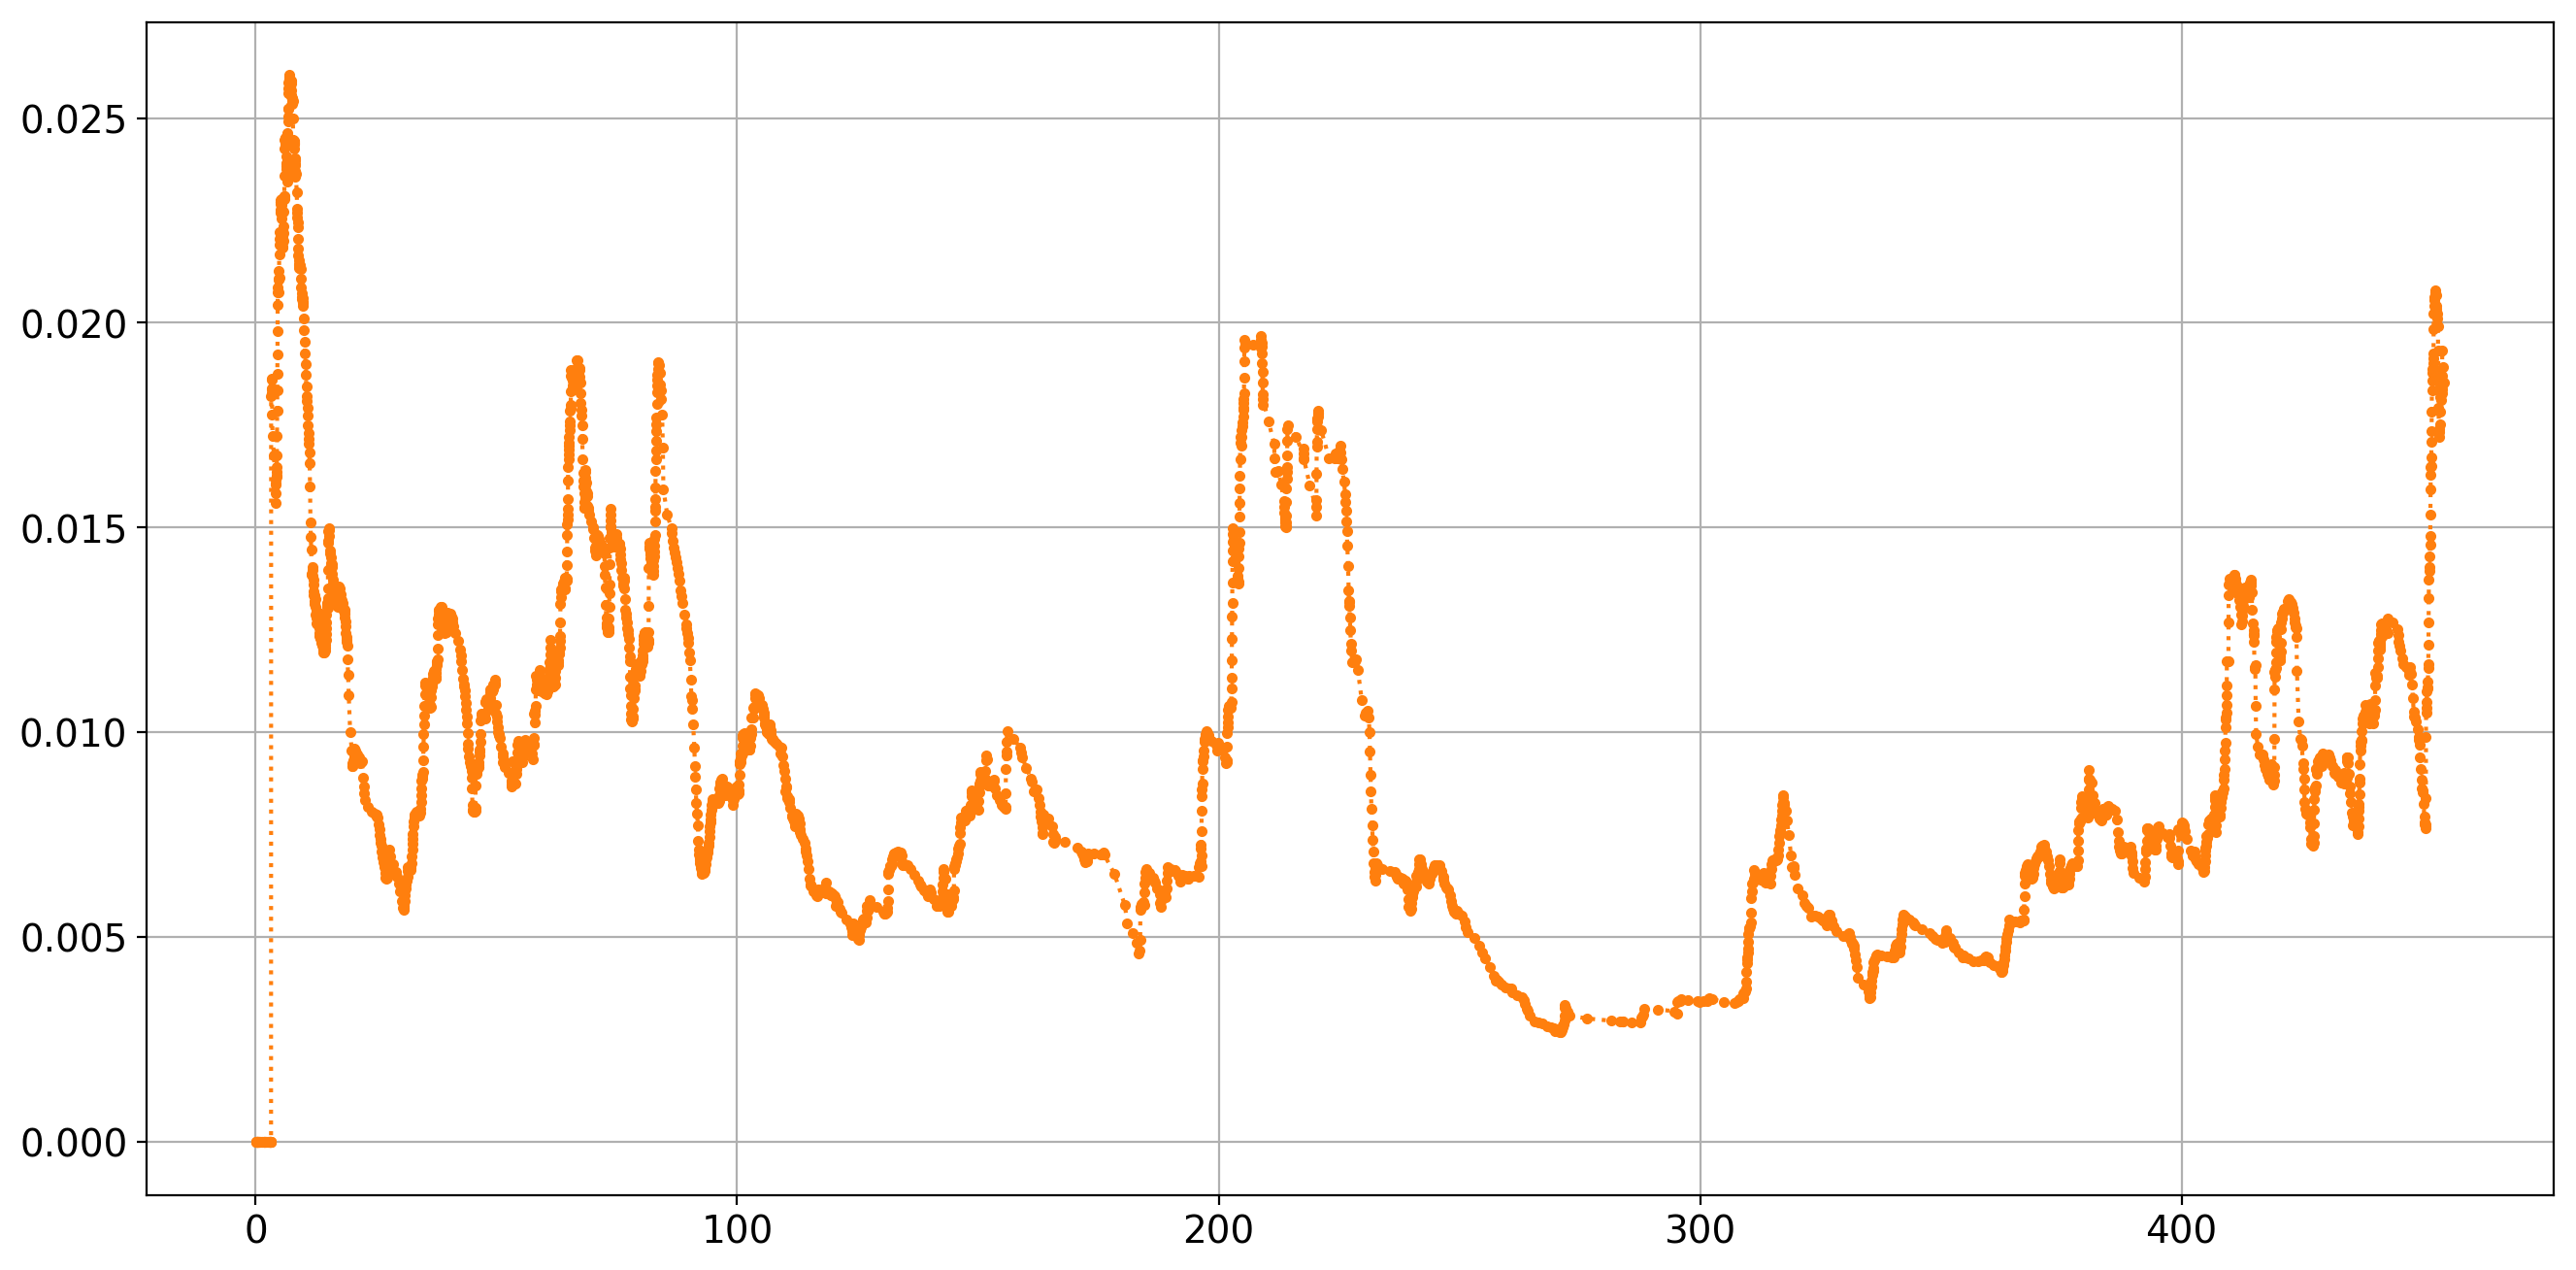

In [18]:
rway['gradient'] = 1./pd.np.sqrt(dxy**2).sum(axis=1)
rway['gradient'] = rway['gradient'].rolling(window = 50).mean()
rway['gradient'].fillna(0, inplace=True)

plt.figure(figsize=(16,8), dpi=200, facecolor='white')
plt.plot(rway['cumdist']/1e3, rway['gradient'], ':.', color='C1');
plt.grid()

### 2) Second attempt: curvature metric
Inspired from Wolfram, http://mathworld.wolfram.com/Curvature.html, we use the following equation for curvature:

$\kappa = \frac{x'y'' - y'x''}{(x'² + y'²)^{3/2}}$

Since we do not care for the direction of the curve (left or right - dizziness any way) we use the absolute value.

In [10]:
# Fetch gradients already calculated
d1x = dxy[:, 0]
d1y = dxy[:, 1]
d2x = d2xy[:, 0]
d2y = d2xy[:, 1]
# Estimate curvature (k)
rway['k'] = (d1x*d2y - d1y*d2x)/pd.np.power(d1x*d1x + d1y*d1y, 3/2.0)

#### Add moving average to smooth the curve

In [11]:
# Ignore direction of curve
rway['k'] = rway['k'].fillna(0).abs()
rway['k'] = rway['k'].rolling(window = 50).mean()
rway['k'].fillna(0, inplace=True)

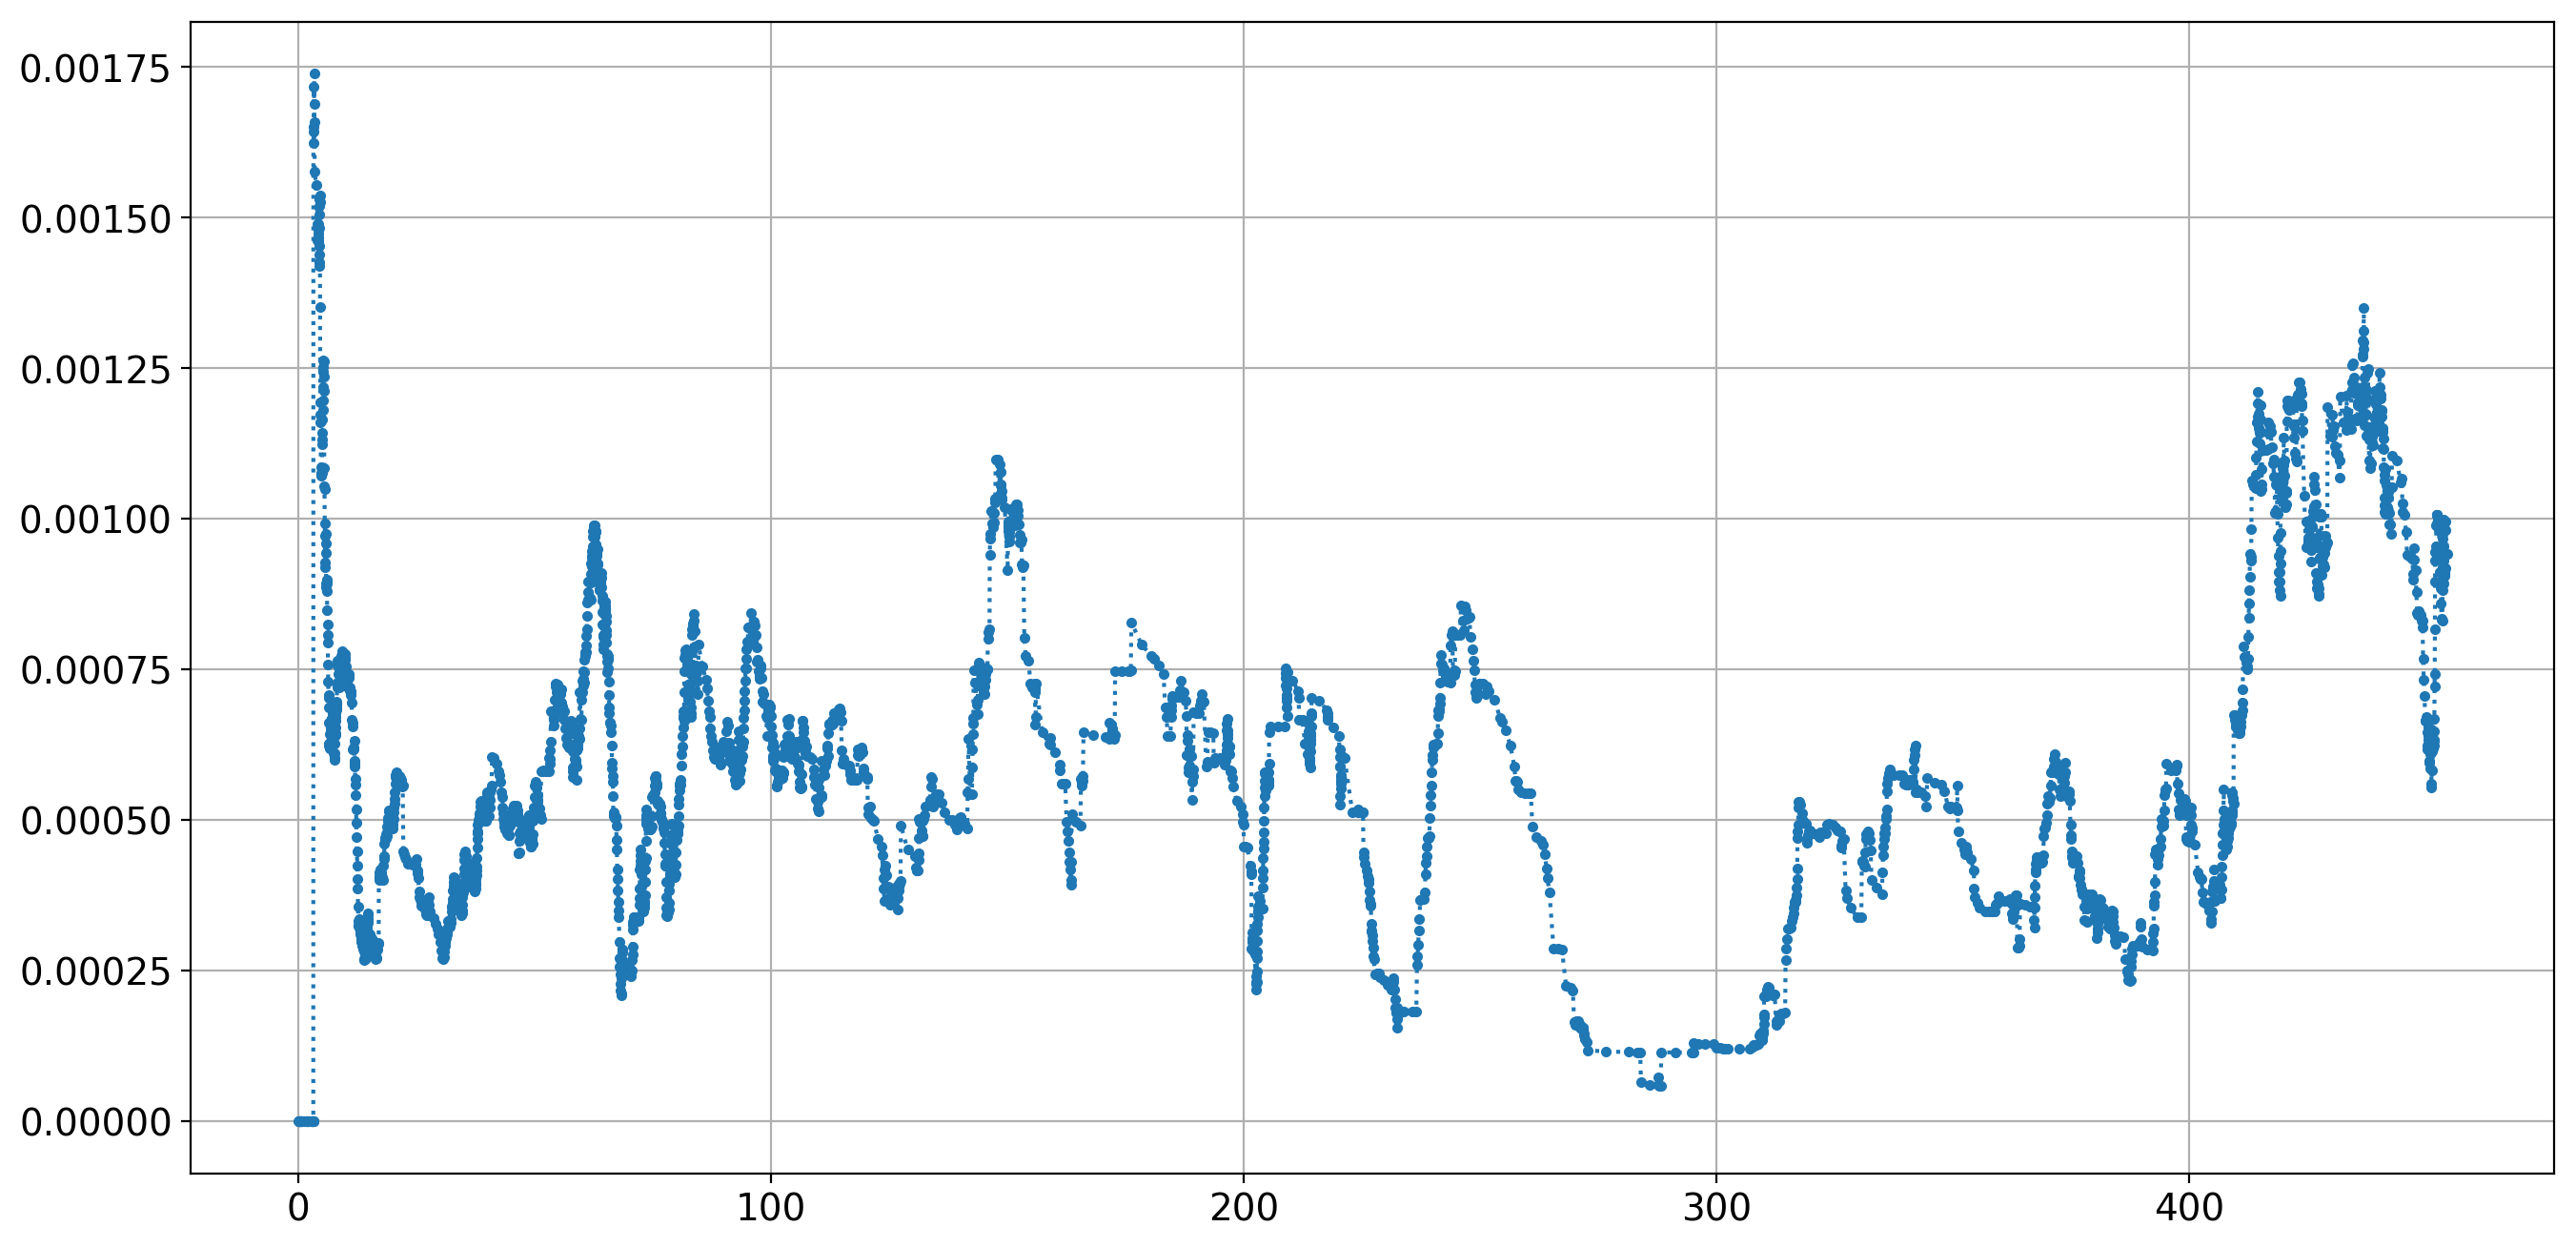

In [19]:
plt.figure(figsize=(16,8), dpi=200, facecolor='white')
plt.plot(rway['cumdist']/1e3, rway['k'], ':.')
plt.grid()

## Get nearby stations for plotting
To get an understanding of where we are along the track, we extract Open Street Map cities and towns close to the railway. To allow for plotting their positions as cumulative distance along the route are calculated.

In [13]:
# Get nearby stations
stations = pd.read_sql("""
    SELECT DISTINCT
        name,
        place,
        ST_X(way) x,
        ST_Y(way) y,
        ST_Distance(way, (
            SELECT ST_Transform(way, 3006) FROM planet_osm_point
            WHERE osm_id  = {startpoint}
        )) AS dist_from_dest
    FROM (
        SELECT
            p.name,
            p.place,
            ST_Transform(p.way, 3006) way
        FROM planet_osm_point p
        INNER JOIN planet_osm_line l
            ON ST_DWithin(l.way, p.way, 1000)
            /* SRID 3857 not meters but fair enough for filter here */
        WHERE 
            p.place in ('city', 'town')
            AND l.osm_id = {railway}
    ) pdump
""".format(startpoint=start_osm_point_id, railway=railway_osm_line_in), conn)

stations.head(3)

,name,place,x,y,dist_from_dest
0,Alingsås,town,353910.753121,6.423579e+06,356582.616469
1,Falköping,town,414950.560330,6.448494e+06,290847.954633
2,Flen,town,591153.073451,6.547459e+06,89262.045993


In [14]:
# Find the closest cumulative distance to each city/town
stations['cumdist'] = 0.0
stations['k'] = 0.0
for i, row in stations.iterrows():
    rway_ind = (
        rway['dist_from_dest'] - row['dist_from_dest']
    ).abs().argsort().iloc[0]
    stations.at[i, 'cumdist'] = rway['cumdist'].iloc[rway_ind]
    stations.at[i, 'k'] = rway['k'].iloc[rway_ind]
stations.head()

,name,place,x,y,dist_from_dest,cumdist,k
0,Alingsås,town,353910.753121,6.423579e+06,356582.616469,409294.854125,0.000532
1,Falköping,town,414950.560330,6.448494e+06,290847.954633,341213.694357,0.000565
2,Flen,town,591153.073451,6.547459e+06,89262.045993,108742.112071,0.000601
3,Gnesta,town,632464.036152,6.547399e+06,53289.875705,64534.262957,0.000791
4,Göteborg,city,319298.130950,6.400161e+06,398017.503793,454552.753633,0.000941


## Plot dizziness score over distance from Stockholm

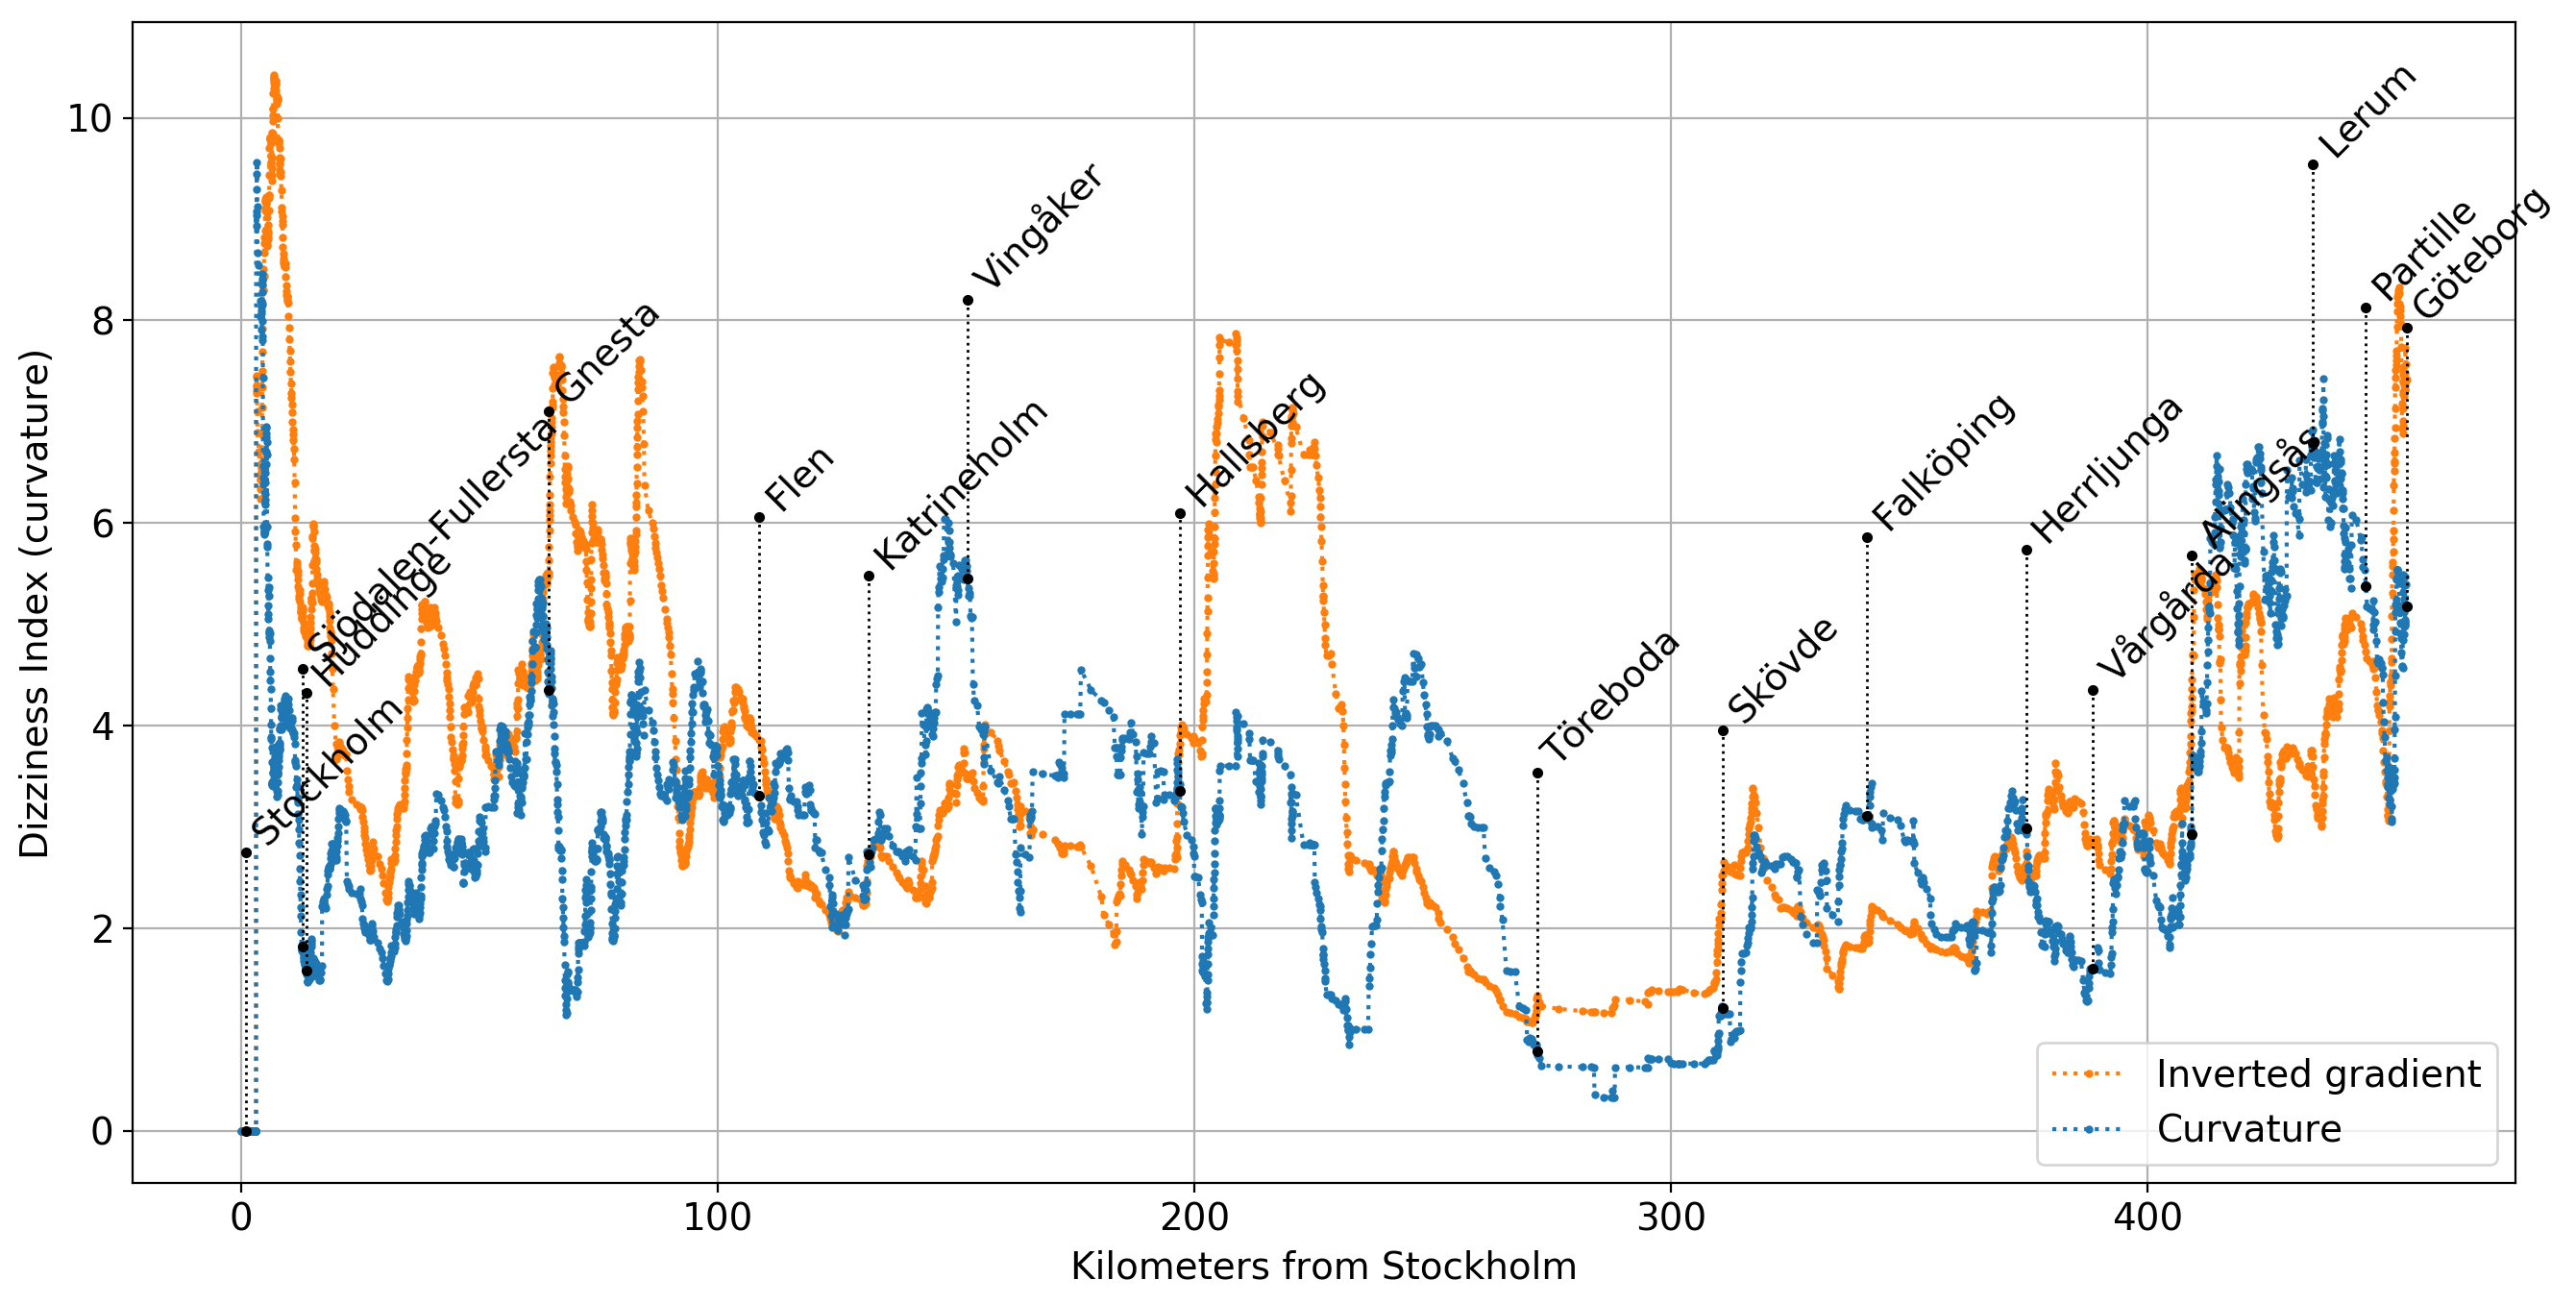

In [20]:
scaley1 = 5500.
scaley2 = 400.
txt_offset = .0005*scaley1
plt.figure(figsize=(16,8), dpi=200, facecolor='white')
plt.plot(rway['cumdist']/1e3, rway['gradient']*scaley2, ':.', markersize=4, color='C1')
plt.plot(rway['cumdist']/1e3, rway['k']*scaley1, ':.', markersize=4, color='C0')
for i, row in stations.iterrows():
    # Add text markers for the stations
    tx = row['cumdist']/1e3
    ty = row['k']*scaley1
    plt.text(tx, ty + txt_offset, row['name'], rotation=45, va='bottom');
    plt.plot([tx, tx], [ty, ty + txt_offset], 'k:.', linewidth=1)
plt.grid()
plt.legend(('Inverted gradient', 'Curvature'), loc=4)
plt.ylabel('Dizziness Index (curvature)');
plt.xlabel('Kilometers from Stockholm');

## Plot dizziness over an actual map

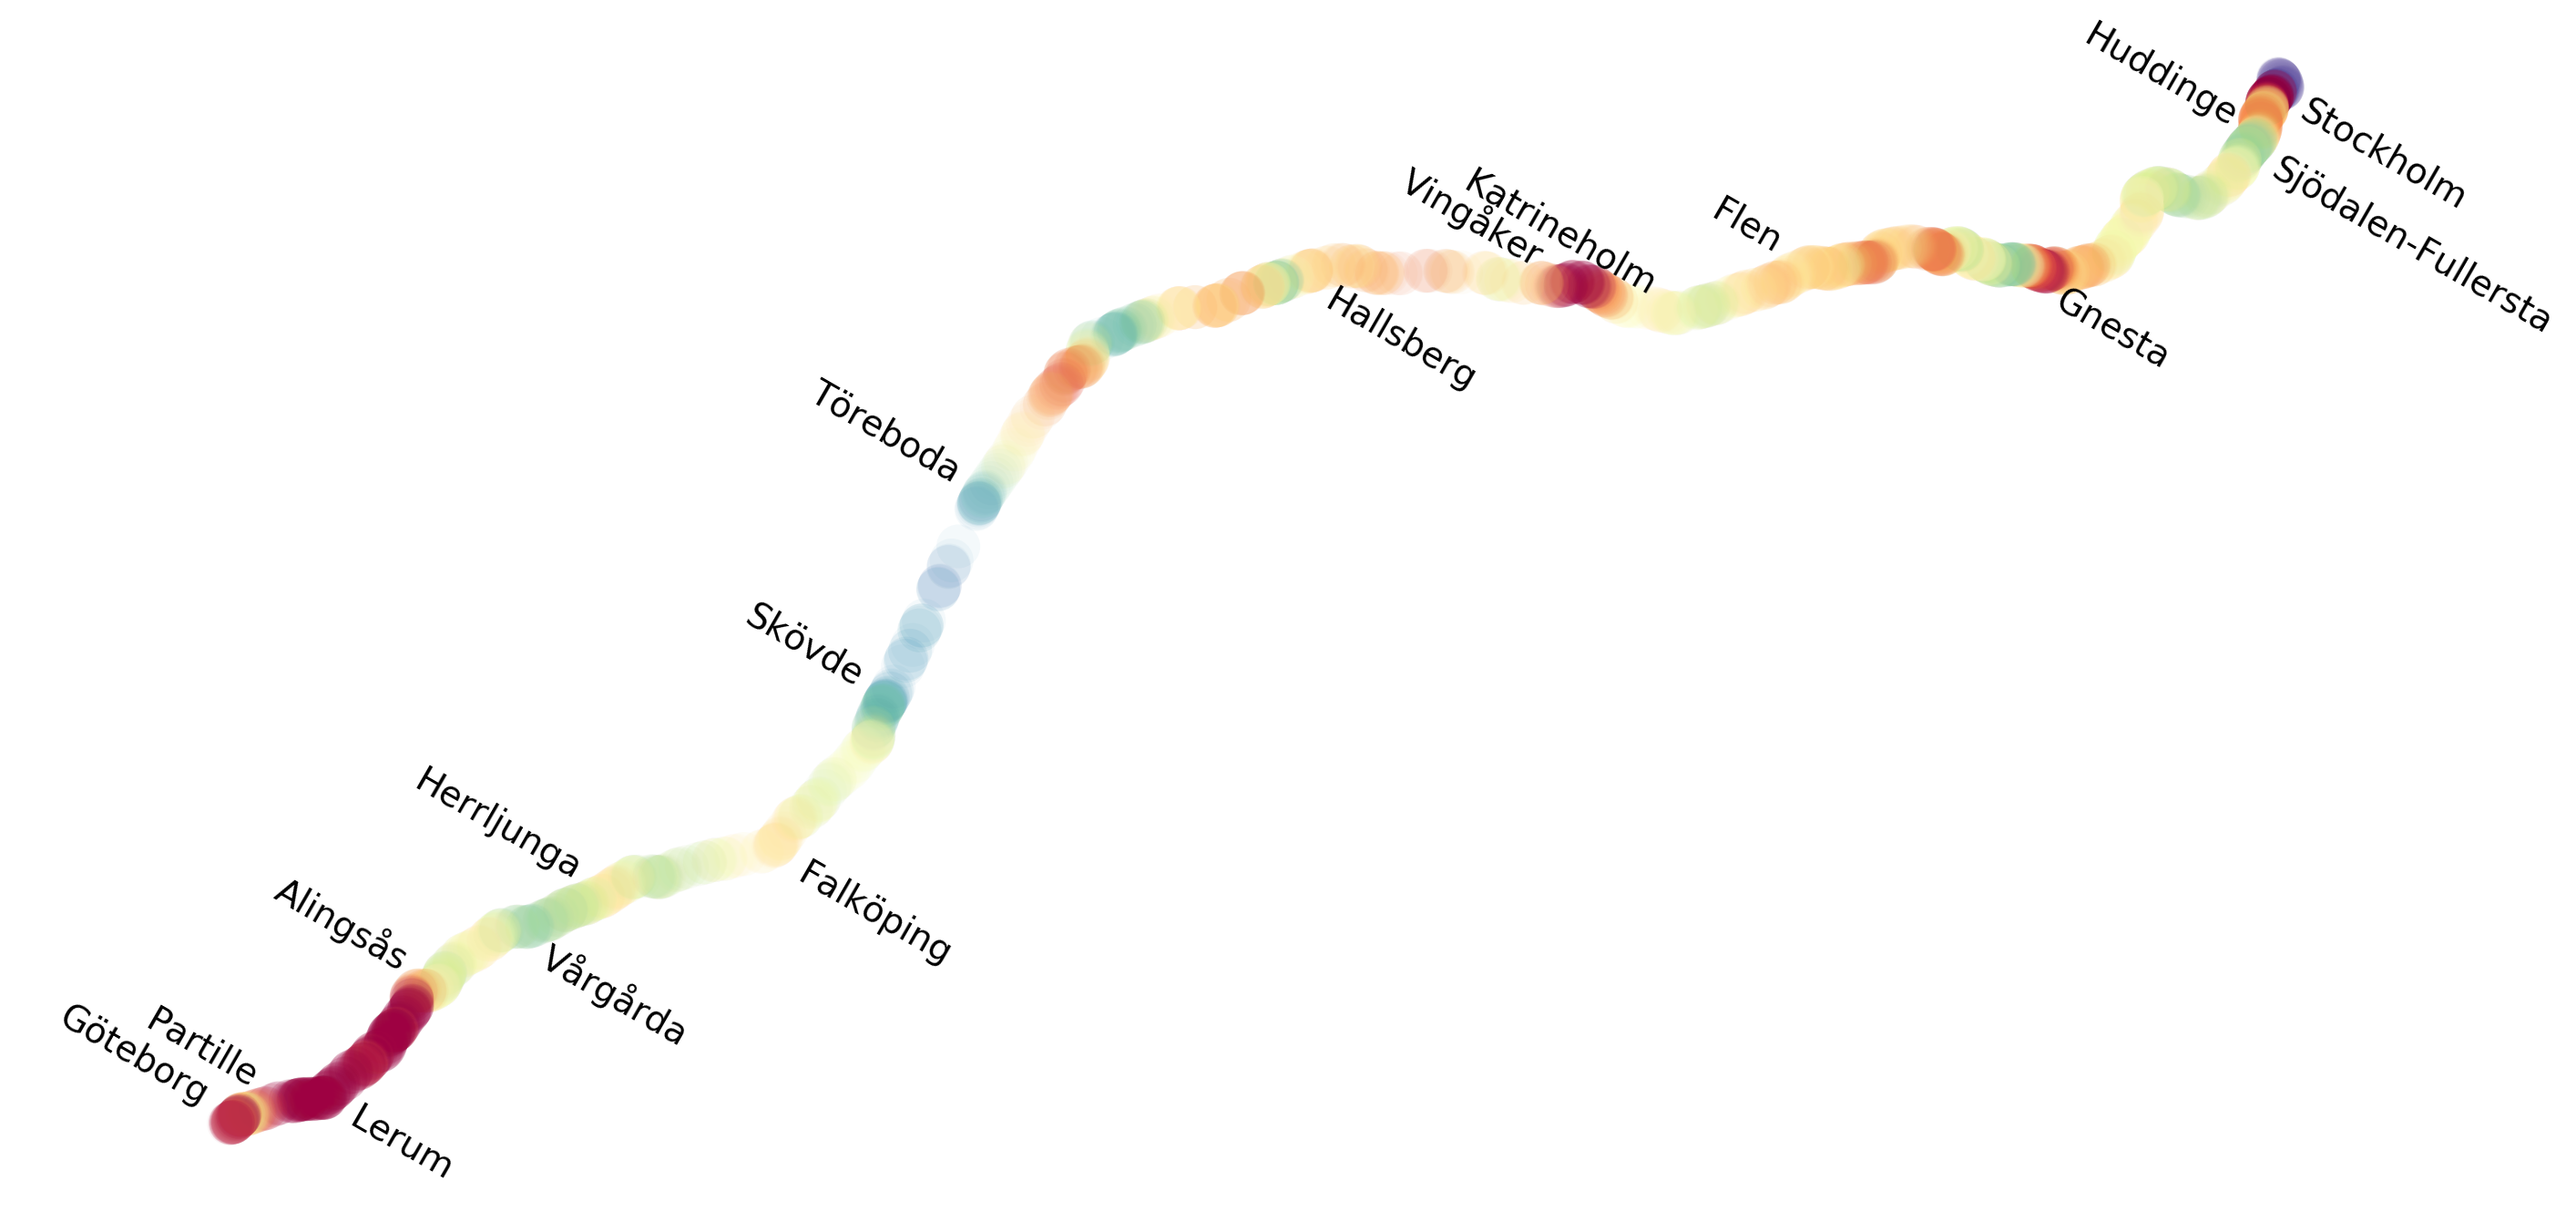

In [21]:
plt.figure(figsize=(16,8), dpi=200, facecolor='white')
rway['k_sat'] = pd.np.minimum(rway['k'], 0.001)
plt.scatter(rway['x']/1e3, rway['y']/1e3, c=rway['k_sat'], 
            lw=0, s=300, alpha=.05, cmap='Spectral_r');
plt.axis('equal')

for i, row in stations.iterrows():
    # Add text markers for the stations
    if (i%2 == 0) | (row['name'] == 'Huddinge'):
        plt.text(row['x']/1000.-2, row['y']/1000.+2, row['name'], 
                 rotation=-30, va='bottom', ha='right');
    else:
        plt.text(row['x']/1000.+2, row['y']/1000.-2, row['name'], 
                 rotation=-30, va='top', ha='left');
plt.axis('off');